<p><img src="car-accident.jpg" alt=""></p>

<p>While the rate of fatal road accidents has been decreasing steadily since the 80s, the past ten years have seen a stagnation in this reduction. Coupled with the increase in number of miles driven in the nation, the total number of traffic related-fatalities has now reached a ten year high and is rapidly increasing.</p>

<p>Per request of the US Department of Transportation, we are currently investigating how to derive a strategy to reduce the incidence of road accidents across the nation. By looking at the demographics of traﬃc accident victims for each US state, we find that there is a lot of variation between states. Now we want to understand if there are patterns in this variation in order to derive suggestions for a policy action plan. In particular, instead of implementing a costly nation-wide plan we want to focus on groups of  states with similar profiles. How can we find such groups in a statistically sound way and communicate the result effectively?</p>

<p>The data we have was originally collected by the National Highway Traffic Safety Administration and the National Association of Insurance Commissioners. This particular dataset was compiled and released as a <a href="https://github.com/fivethirtyeight/data/tree/master/bad-drivers">CSV-file</a> by FiveThirtyEight under the <a href="https://github.com/ﬁvethirtyeight/data">CC-BY4.0 license</a>.</p>

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from urllib.request import urlretrieve

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [9]:

urlretrieve('https://raw.githubusercontent.com/fivethirtyeight/data/master/bad-drivers/bad-drivers.csv',
           'datasets/data_road-accidents.csv')

current_dir = !pwd
print(current_dir , '\n')

file_list = !ls
print(file_list , '\n')

dataset_list = !ls datasets/
print(dataset_list , '\n')

accidents_head = !head -20 datasets/road-accidents.csv
accidents_head

['/e/ProWork/Python/PythonProjects/Reducing Traffic Mortality in the USA'] 

['Reducing Traffic Mortality in the USA.ipynb', 'car-accident.jpg', 'datasets', 'notebook.ipynb', 'road-accidents.csv'] 

['data_road-accidents.csv', 'miles-driven.csv', 'road-accidents.csv'] 



['##### LICENSE #####',
 '# This data set is modified from the original at fivethirtyeight (https://github.com/fivethirtyeight/data/tree/master/bad-drivers)',
 '# and it is released under CC BY 4.0 (https://creativecommons.org/licenses/by/4.0/)',
 '##### COLUMN ABBREVIATIONS #####',
 '# drvr_fatl_col_bmiles = Number of drivers involved in fatal collisions per billion miles (2011)',
 '# perc_fatl_speed = Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding (2009)',
 '# perc_fatl_alcohol = Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired (2011)',
 '# perc_fatl_1st_time = Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents (2011)',
 '##### DATA BEGIN #####',
 'state|drvr_fatl_col_bmiles|perc_fatl_speed|perc_fatl_alcohol|perc_fatl_1st_time',
 'Alabama|18.8|39|30|80',
 'Alaska|18.1|41|25|94',
 'Arizona|18.6|35|28|96',
 'Arkansas|22.4|18|26|95',
 'California|12|35|28|89',
 'Colorado|13.6|37|28|95',

In [7]:
car_acc = pd.read_csv('datasets/road-accidents.csv', comment = '#', sep='|')

rows, cols = car_acc.shape
print('There are {} rows and {} columns.\n'.format(rows, cols))

print(car_acc.info())
car_acc.tail()

There are 51 rows and 5 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 51 non-null     object 
 1   drvr_fatl_col_bmiles  51 non-null     float64
 2   perc_fatl_speed       51 non-null     int64  
 3   perc_fatl_alcohol     51 non-null     int64  
 4   perc_fatl_1st_time    51 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.1+ KB
None


,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
46,Virginia,12.7,19,27,88
47,Washington,10.6,42,33,86
48,West Virginia,23.8,34,28,87
49,Wisconsin,13.8,36,33,84
50,Wyoming,17.4,42,32,90


,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
count,51.000000,51.000000,51.000000,51.00000
mean,15.790196,31.725490,30.686275,88.72549
std,4.122002,9.633438,5.132213,6.96011
min,5.900000,13.000000,16.000000,76.00000
25%,12.750000,23.000000,28.000000,83.50000
50%,15.600000,34.000000,30.000000,88.00000
75%,18.500000,38.000000,33.000000,95.00000
max,23.900000,54.000000,44.000000,100.00000


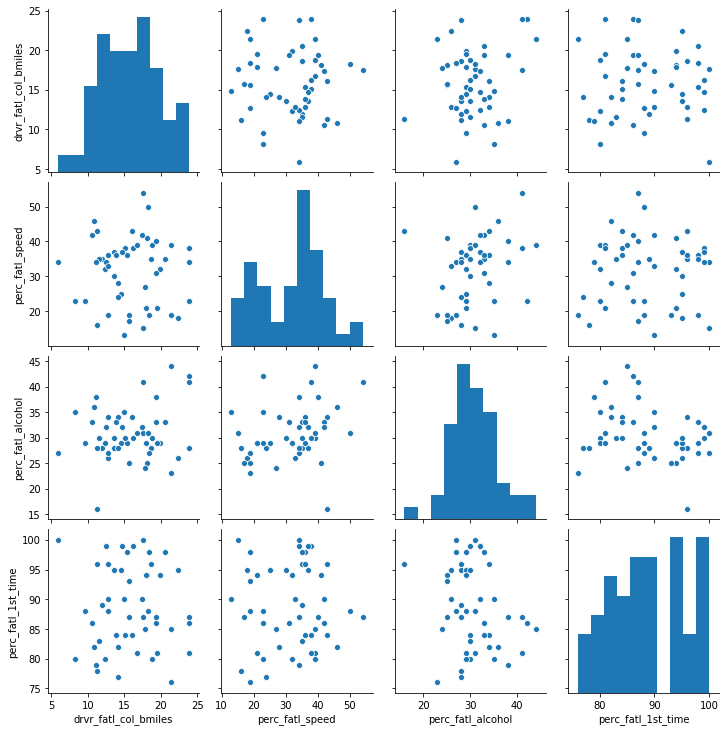

In [11]:
sns.pairplot(data=car_acc)
car_acc.describe()

[Text(0, 0.5, 'state'),
 Text(0, 1.5, 'drvr_fatl_col_bmiles'),
 Text(0, 2.5, 'perc_fatl_speed'),
 Text(0, 3.5, 'perc_fatl_alcohol')]

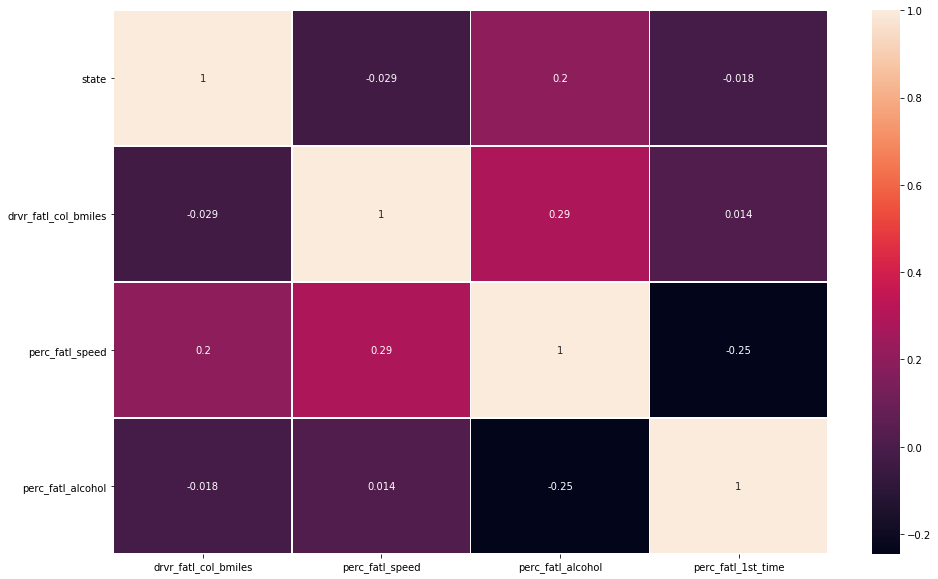

In [17]:

fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(car_acc.corr(), annot=True, linewidths=.5, ax=ax)
ax.set_yticklabels([i for i in car_acc.columns], rotation=0)

<p>From the correlation table, we see that the amount of fatal accidents is most strongly correlated with alcohol consumption (first row). But in addition, we also see that some of the features are correlated with each other, for instance, speeding and alcohol consumption are positively correlated. We, therefore, want to compute the association of the target with each feature while adjusting for the effect of the remaining features. This can be done using multivariate linear regression.</p>
<p>Both the multivariate regression and the correlation measure how strongly the features are associated with the outcome (fatal accidents). When comparing the regression coefficients with the correlation coefficients, we will see that they are slightly different. The reason for this is that the multiple regression computes the association of a feature with an outcome, given the association with all other features, which is not accounted for when calculating the correlation coefficients.</p>
<p>A particularly interesting case is when the correlation coefficient and the regression coefficient of the same feature have opposite signs. How can this be? For example, when a feature A is positively correlated with the outcome Y but also positively correlated with a different feature B that has a negative effect on Y, then the indirect correlation (A-&gt;B-&gt;Y) can overwhelm the direct correlation (A-&gt;Y). In such a case, the regression coefficient of feature A could be positive, while the correlation coefficient is negative. This is sometimes called a <em>masking</em> relationship. Let’s see if the multivariate regression can reveal such a phenomenon.</p>

In [20]:
features = car_acc.drop(['drvr_fatl_col_bmiles','state'], axis=1)
target = car_acc['drvr_fatl_col_bmiles']
# .values.reshape(-1, 1)

reg = linear_model.LinearRegression()
reg.fit(features, target)

fit_coef = reg.coef_
fit_coef

array([-0.04180041,  0.19086404,  0.02473301])

In [26]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA()
pca.fit(features_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The cumulative variance of the first two principal components is 0.79470


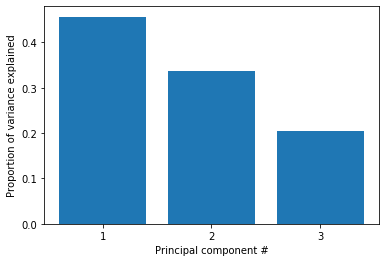

In [30]:
plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
plt.xlabel('Principal component #')
plt.ylabel('Proportion of variance explained')
plt.xticks([1, 2, 3])

two_first_comp_var_exp = pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]
print("The cumulative variance of the first two principal components is {:.5f}".format(two_first_comp_var_exp))
# round(two_first_comp_var_exp, 2)

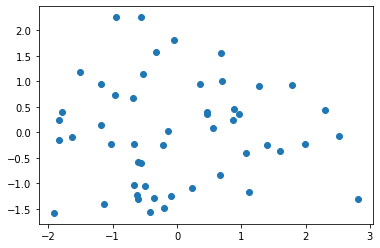

In [31]:
pca = PCA(n_components = 2)
p_comps = pca.fit_transform(features_scaled)

p_comp1 = p_comps[:, 0]
p_comp2 = p_comps[:, 1]

plt.scatter(x=p_comp1,y= p_comp2)
plt.show()

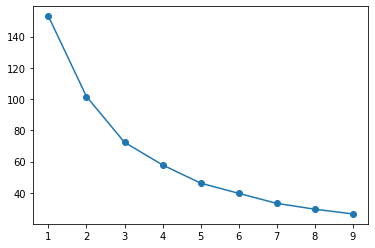

In [33]:
ks = range(1, 10)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=8)
    km.fit(features_scaled)
    inertias.append(km.inertia_)
    
plt.plot(ks, inertias, marker='o')
plt.show()

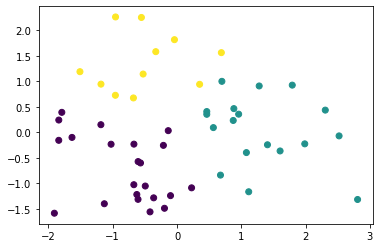

In [34]:
km = KMeans(n_clusters=3, random_state=8)
km.fit(features_scaled)

plt.scatter(x=p_comp1,y= p_comp2, c=km.labels_)
plt.show()

,cluster,measurement,percent
0,1,perc_fatl_speed,39
1,0,perc_fatl_speed,41
2,0,perc_fatl_speed,35
3,0,perc_fatl_speed,18
4,0,perc_fatl_speed,35


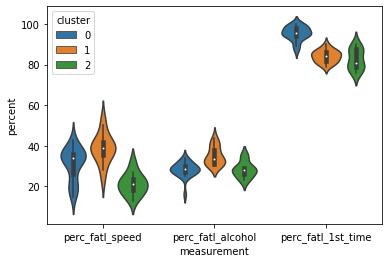

In [36]:
car_acc['cluster'] = km.labels_

melt_car = pd.melt(car_acc, id_vars=['cluster'], value_vars=['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time'],
                   var_name='measurement', value_name='percent' )
display(melt_car.head())

sns.violinplot(x='measurement', y='percent', data =melt_car, hue='cluster')

Now to compute the number of accidents within each cluster
<p>it is clear that different groups of states may require different interventions. Since resources and time are limited, it is useful to start off with an intervention in one of the three groups first. Which group would this be? To determine this, we will include data on how many miles are driven in each state, because this will help compute the total number of fatal accidents in each state.</p>

,count,mean,sum
cluster,,,
0,22,898.378595,19764.3291
1,18,911.406439,16405.3159
2,11,860.505945,9465.5654


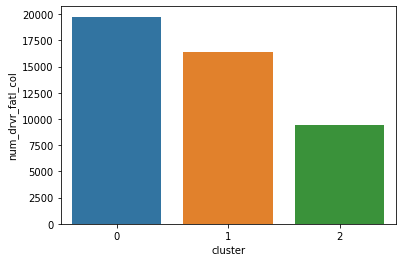

In [41]:
miles_driven = pd.read_csv('datasets/miles-driven.csv', sep='|')
car_acc_miles = car_acc.merge(miles_driven, on='state')
car_acc_miles['num_drvr_fatl_col'] = car_acc_miles['drvr_fatl_col_bmiles']*car_acc_miles['million_miles_annually']/1000

x = car_acc_miles.groupby('cluster')['cluster'].mean()
y = car_acc_miles.groupby('cluster')['num_drvr_fatl_col'].sum()
sns.barplot(x= x, y= y, data=car_acc_miles, ci=None)

count_mean_sum = y = car_acc_miles.groupby('cluster')['num_drvr_fatl_col'].agg(['count', 'mean', 'sum'])
display(count_mean_sum)

In [42]:
cluster_num = 0